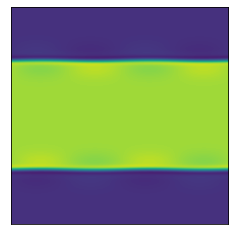

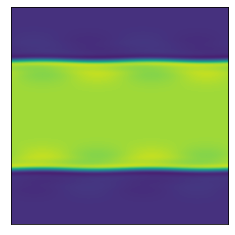

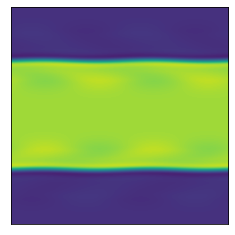

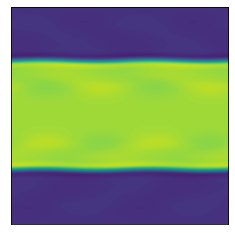

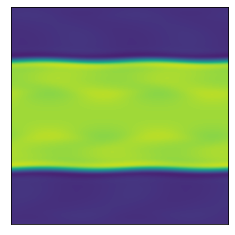

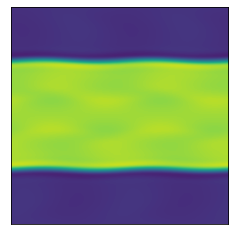

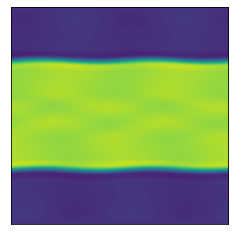

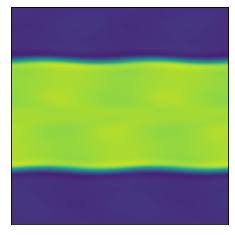

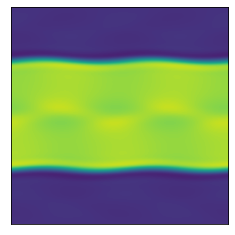

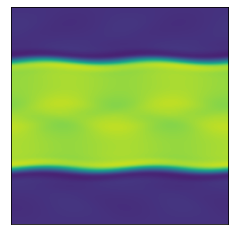

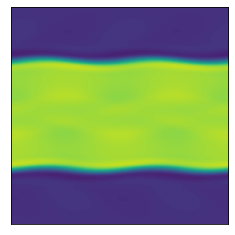

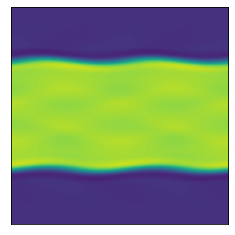

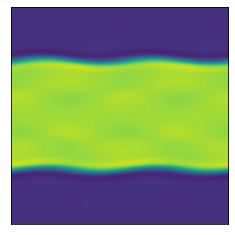

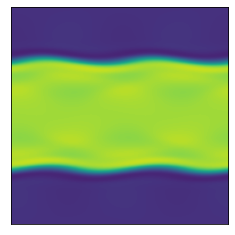

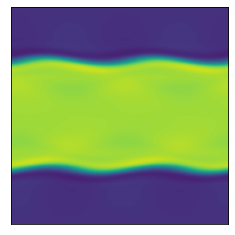

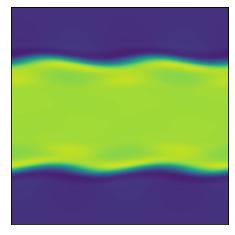

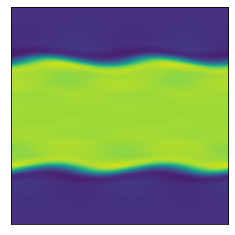

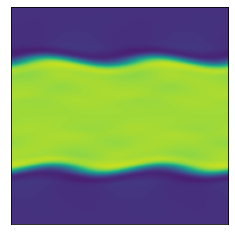

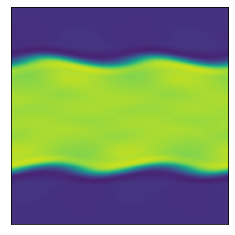

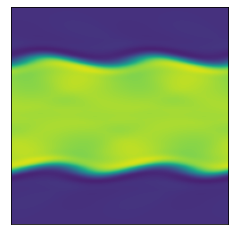

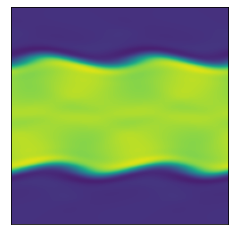

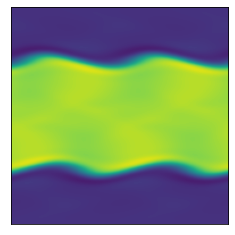

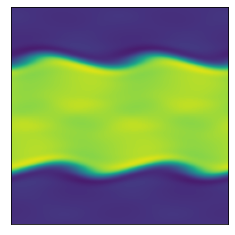

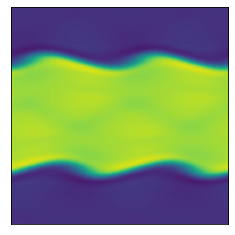

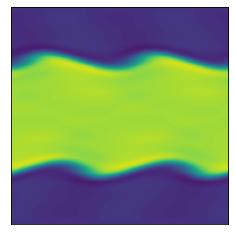

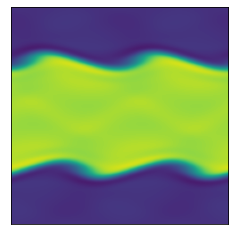

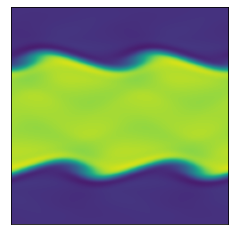

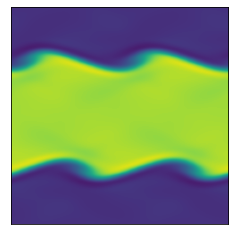

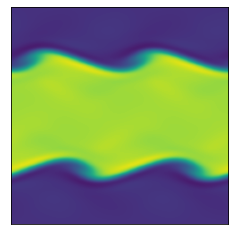

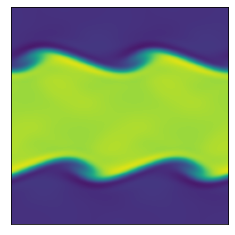

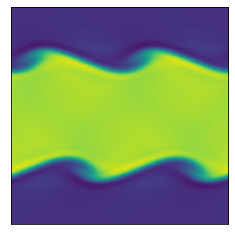

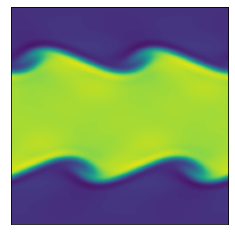

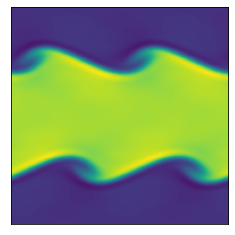

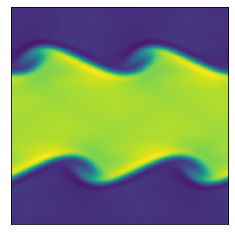

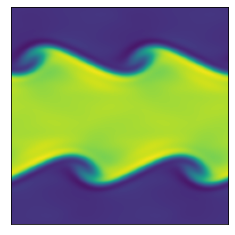

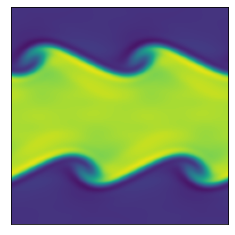

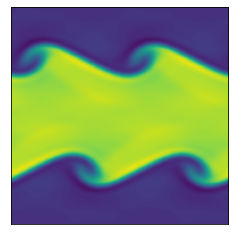

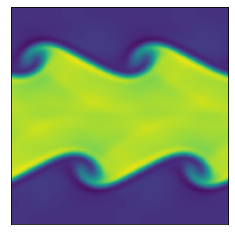

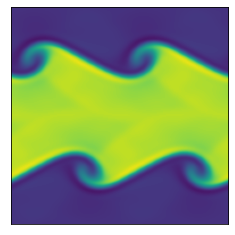

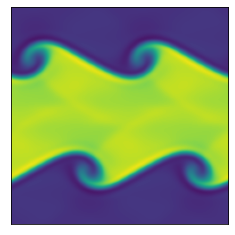

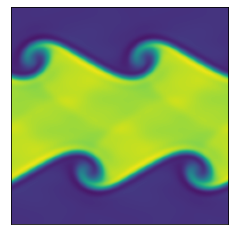

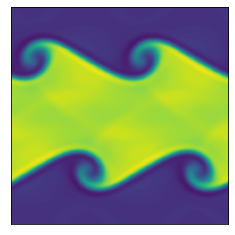

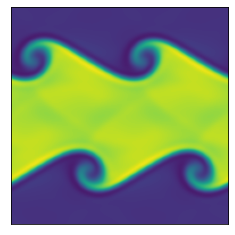

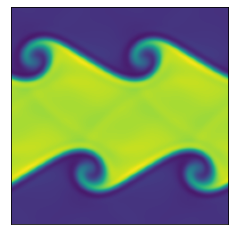

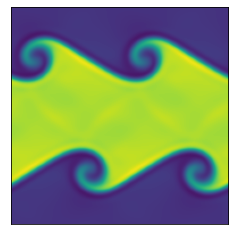

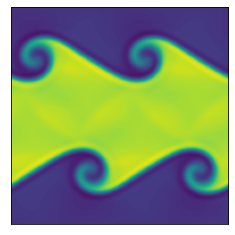

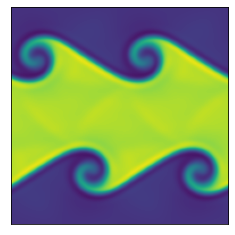

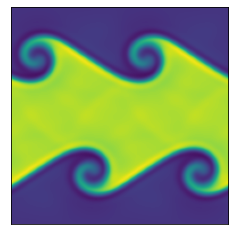

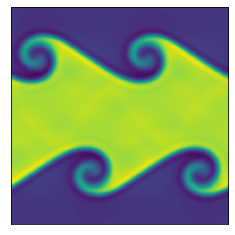

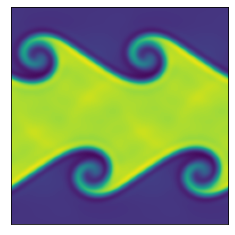

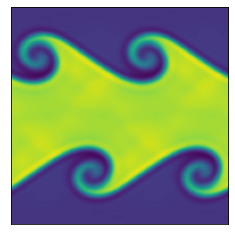

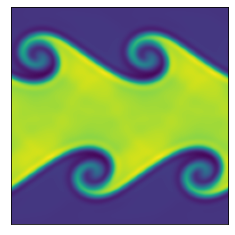

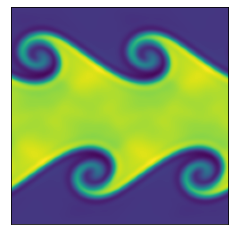

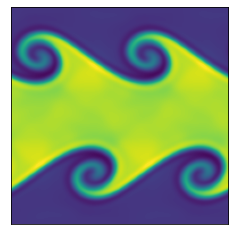

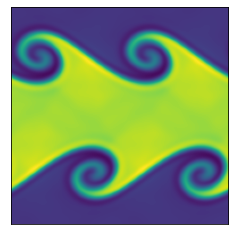

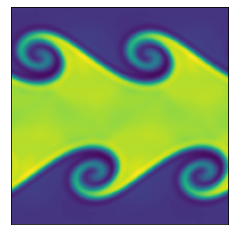

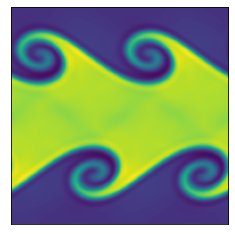

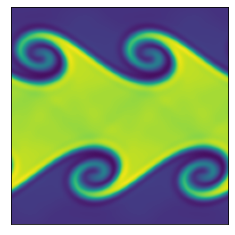

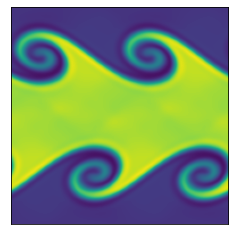

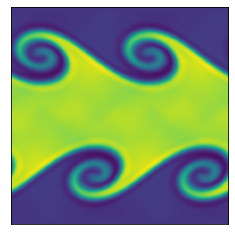

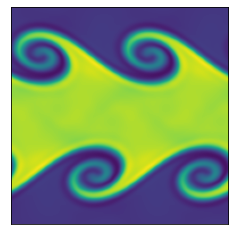

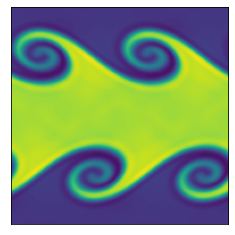

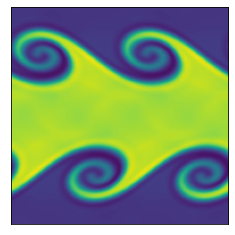

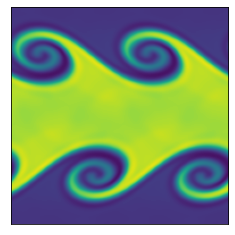

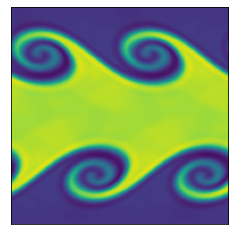

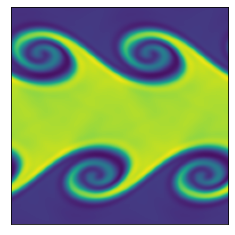

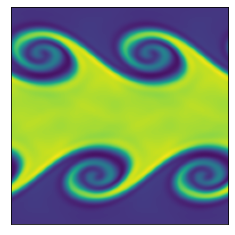

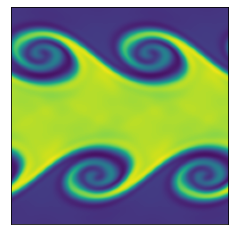

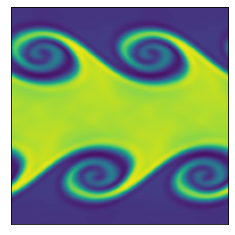

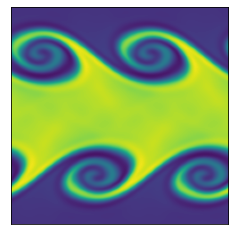

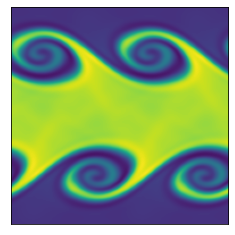

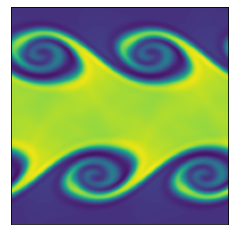

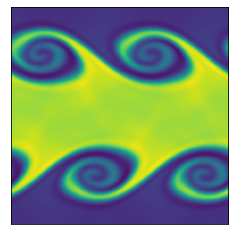

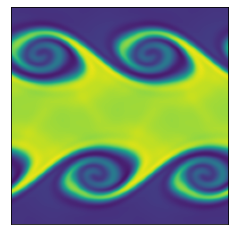

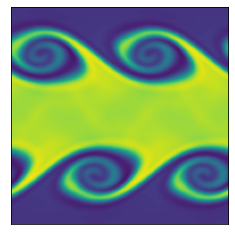

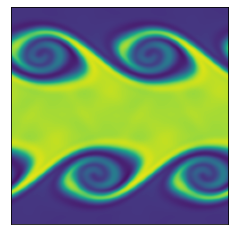

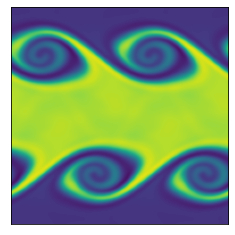

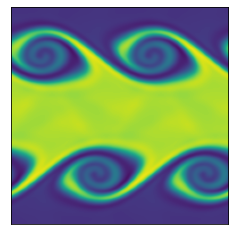

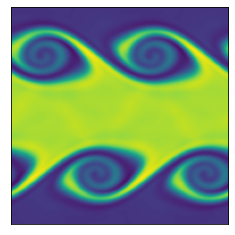

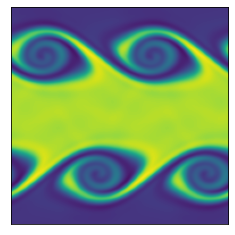

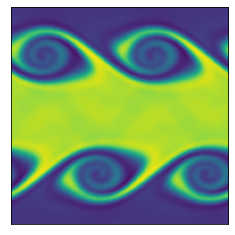

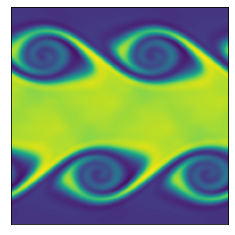

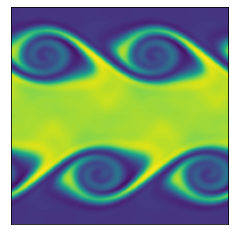

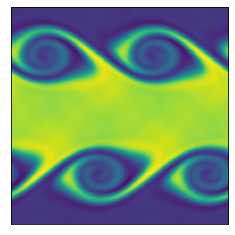

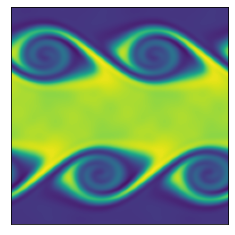

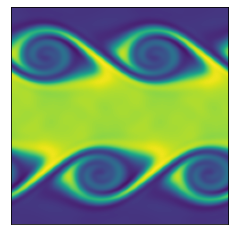

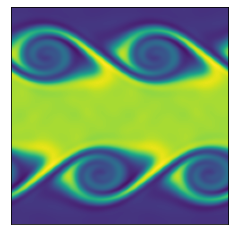

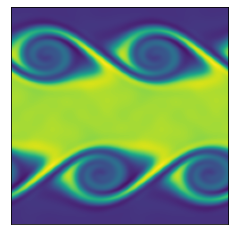

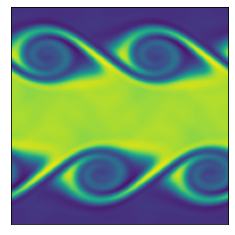

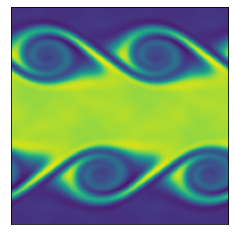

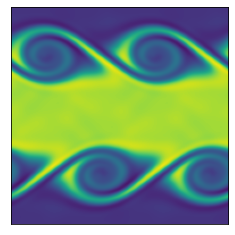

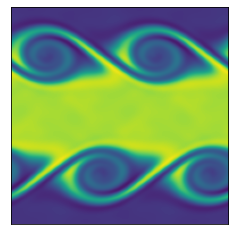

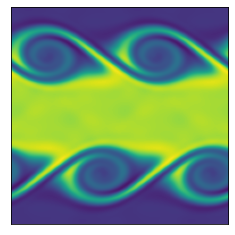

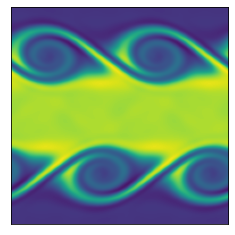

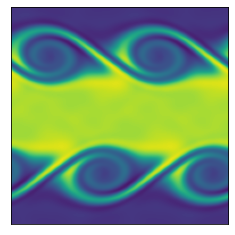

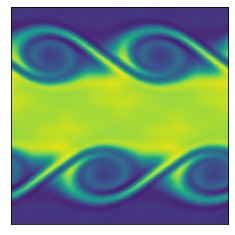

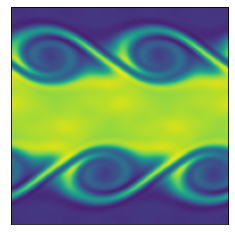

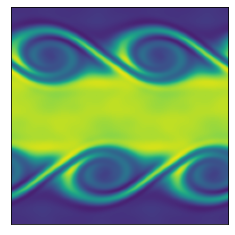

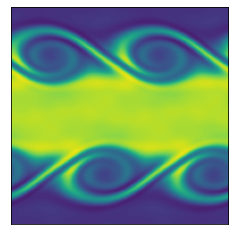

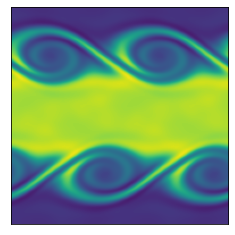

In [3]:
import matplotlib.pyplot as plt
import numpy as np

"""
Create Your Own Finite Volume Fluid Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the Kelvin Helmholtz Instability
In the compressible Euler equations

"""

def getConserved( rho, vx, vy, P, gamma, vol ):
	"""
    Calculate the conserved variable from the primitive
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	gamma    is ideal gas gamma
	vol      is cell volume
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	"""
	Mass   = rho * vol
	Momx   = rho * vx * vol
	Momy   = rho * vy * vol
	Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol
	
	return Mass, Momx, Momy, Energy


def getPrimitive( Mass, Momx, Momy, Energy, gamma, vol ):
	"""
    Calculate the primitive variable from the conservative
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	gamma    is ideal gas gamma
	vol      is cell volume
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""
	rho = Mass / vol
	vx  = Momx / rho / vol
	vy  = Momy / rho / vol
	P   = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)
	
	return rho, vx, vy, P

def getGradient(f, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	f_dx = ( np.roll(f,R,axis=0) - np.roll(f,L,axis=0) ) / (2*dx)
	f_dy = ( np.roll(f,R,axis=1) - np.roll(f,L,axis=1) ) / (2*dx)
	
	return f_dx, f_dy

def slopeLimit(f, dx, f_dx, f_dy):
	"""
    Apply slope limiter to slopes
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	f_dx = np.maximum(0., np.minimum(1., ( (f-np.roll(f,L,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dx = np.maximum(0., np.minimum(1., (-(f-np.roll(f,R,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dy = np.maximum(0., np.minimum(1., ( (f-np.roll(f,L,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
	f_dy = np.maximum(0., np.minimum(1., (-(f-np.roll(f,R,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
	
	return f_dx, f_dy


def extrapolateInSpaceToFace(f, f_dx, f_dy, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	f_dx     is a matrix of the field x-derivatives
	f_dy     is a matrix of the field y-derivatives
	dx       is the cell size
	f_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis 
	f_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis 
	f_YR     is a matrix of spatial-extrapolated values on `left' face along y-axis 
	f_YR     is a matrix of spatial-extrapolated values on `right' face along y-axis 
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	f_XL = f - f_dx * dx/2
	f_XL = np.roll(f_XL,R,axis=0)
	f_XR = f + f_dx * dx/2
	
	f_YL = f - f_dy * dx/2
	f_YL = np.roll(f_YL,R,axis=1)
	f_YR = f + f_dy * dx/2
	
	return f_XL, f_XR, f_YL, f_YR
	

def applyFluxes(F, flux_F_X, flux_F_Y, dx, dt):
	"""
    Apply fluxes to conserved variables
	F        is a matrix of the conserved variable field
	flux_F_X is a matrix of the x-dir fluxes
	flux_F_Y is a matrix of the y-dir fluxes
	dx       is the cell size
	dt       is the timestep
	"""
	# directions for np.roll() 
	R = -1   # right
	L = 1    # left
	
	# update solution
	F += - dt * dx * flux_F_X
	F +=   dt * dx * np.roll(flux_F_X,L,axis=0)
	F += - dt * dx * flux_F_Y
	F +=   dt * dx * np.roll(flux_F_Y,L,axis=1)
	
	return F


def getFlux(rho_L, rho_R, vx_L, vx_R, vy_L, vy_R, P_L, P_R, gamma):
	"""
    Calculate fluxed between 2 states with local Lax-Friedrichs/Rusanov rule 
	rho_L        is a matrix of left-state  density
	rho_R        is a matrix of right-state density
	vx_L         is a matrix of left-state  x-velocity
	vx_R         is a matrix of right-state x-velocity
	vy_L         is a matrix of left-state  y-velocity
	vy_R         is a matrix of right-state y-velocity
	P_L          is a matrix of left-state  pressure
	P_R          is a matrix of right-state pressure
	gamma        is the ideal gas gamma
	flux_Mass    is the matrix of mass fluxes
	flux_Momx    is the matrix of x-momentum fluxes
	flux_Momy    is the matrix of y-momentum fluxes
	flux_Energy  is the matrix of energy fluxes
	"""
	
	# left and right energies
	en_L = P_L/(gamma-1)+0.5*rho_L * (vx_L**2+vy_L**2)
	en_R = P_R/(gamma-1)+0.5*rho_R * (vx_R**2+vy_R**2)

	# compute star (averaged) states
	rho_star  = 0.5*(rho_L + rho_R)
	momx_star = 0.5*(rho_L * vx_L + rho_R * vx_R)
	momy_star = 0.5*(rho_L * vy_L + rho_R * vy_R)
	en_star   = 0.5*(en_L + en_R)
	
	P_star = (gamma-1)*(en_star-0.5*(momx_star**2+momy_star**2)/rho_star)
	
	# compute fluxes (local Lax-Friedrichs/Rusanov)
	flux_Mass   = momx_star
	flux_Momx   = momx_star**2/rho_star + P_star
	flux_Momy   = momx_star * momy_star/rho_star
	flux_Energy = (en_star+P_star) * momx_star/rho_star
	
	# find wavespeeds
	C_L = np.sqrt(gamma*P_L/rho_L) + np.abs(vx_L)
	C_R = np.sqrt(gamma*P_R/rho_R) + np.abs(vx_R)
	C = np.maximum( C_L, C_R )
	
	# add stabilizing diffusive term
	flux_Mass   -= C * 0.5 * (rho_L - rho_R)
	flux_Momx   -= C * 0.5 * (rho_L * vx_L - rho_R * vx_R)
	flux_Momy   -= C * 0.5 * (rho_L * vy_L - rho_R * vy_R)
	flux_Energy -= C * 0.5 * ( en_L - en_R )

	return flux_Mass, flux_Momx, flux_Momy, flux_Energy


def solve(rho0=1,vx0=-0.5,w0=0.1,P0=2.5):
	""" Finite Volume simulation """
	
	# Simulation parameters
	N                      = 192 # resolution
	boxsize                = 1.
	gamma                  = 5/3 # ideal gas gamma
	courant_fac            = 0.4
	t                      = 0
	tEnd                   = 2
	tOut                   = 0.02 # draw frequency
	useSlopeLimiting       = False
	plotRealTime = True # switch on for plotting as the simulation goes along
	
	# Mesh
	dx = boxsize / N
	vol = dx**2
	xlin = np.linspace(0.5*dx, boxsize-0.5*dx, N)
	Y, X = np.meshgrid( xlin, xlin )
	
	# Generate Initial Conditions - opposite moving streams with perturbation
# 	w0 = 0.1
	sigma = 0.05/np.sqrt(2.)
	rho = 1. + (np.abs(Y-0.5) < 0.25)
	vx = -0.5 + (np.abs(Y-0.5)<0.25)
	vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
	P = P0 * np.ones(X.shape)

	# Get conserved variables
	Mass, Momx, Momy, Energy = getConserved( rho, vx, vy, P, gamma, vol )
	
	# prep figure
# 	fig = plt.figure(figsize=(4,4), dpi=80)
	outputCount = 1;count=-1;res=[]
	
	# Simulation Main Loop


	while t < tEnd:
		count+=1;
#         print(count)
		# get Primitive variables
		rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol )
		
		# get time step (CFL) = dx / max signal speed
		dt = courant_fac * np.min( dx / (np.sqrt( gamma*P/rho ) + np.sqrt(vx**2+vy**2)) );#print(dt)
		plotThisTurn = False
		if t + dt > outputCount*tOut:
			dt = outputCount*tOut - t
			plotThisTurn = True
		
		# calculate gradients
		rho_dx, rho_dy = getGradient(rho, dx)
		vx_dx,  vx_dy  = getGradient(vx,  dx)
		vy_dx,  vy_dy  = getGradient(vy,  dx)
		P_dx,   P_dy   = getGradient(P,   dx)
		
		# slope limit gradients
		if useSlopeLimiting:
			rho_dx, rho_dy = slopeLimit(rho, dx, rho_dx, rho_dy)
			vx_dx,  vx_dy  = slopeLimit(vx , dx, vx_dx,  vx_dy )
			vy_dx,  vy_dy  = slopeLimit(vy , dx, vy_dx,  vy_dy )
			P_dx,   P_dy   = slopeLimit(P  , dx, P_dx,   P_dy  )
		
		# extrapolate half-step in time
		rho_prime = rho - 0.5*dt * ( vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
		vx_prime  = vx  - 0.5*dt * ( vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
		vy_prime  = vy  - 0.5*dt * ( vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
		P_prime   = P   - 0.5*dt * ( gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )
		
		# extrapolate in space to face centers
		rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
		vx_XL,  vx_XR,  vx_YL,  vx_YR  = extrapolateInSpaceToFace(vx_prime,  vx_dx,  vx_dy,  dx)
		vy_XL,  vy_XR,  vy_YL,  vy_YR  = extrapolateInSpaceToFace(vy_prime,  vy_dx,  vy_dy,  dx)
		P_XL,   P_XR,   P_YL,   P_YR   = extrapolateInSpaceToFace(P_prime,   P_dx,   P_dy,   dx)
		
		# compute fluxes (local Lax-Friedrichs/Rusanov)
		flux_Mass_X, flux_Momx_X, flux_Momy_X, flux_Energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
		flux_Mass_Y, flux_Momy_Y, flux_Momx_Y, flux_Energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)
		
		# update solution
		Mass   = applyFluxes(Mass, flux_Mass_X, flux_Mass_Y, dx, dt)
		Momx   = applyFluxes(Momx, flux_Momx_X, flux_Momx_Y, dx, dt)
		Momy   = applyFluxes(Momy, flux_Momy_X, flux_Momy_Y, dx, dt)
		Energy = applyFluxes(Energy, flux_Energy_X, flux_Energy_Y, dx, dt)
		
		# update time
		t += dt
		res.append(rho.T)
		#plot in real time - color 1/2 particles blue, other half red
		if (plotRealTime and plotThisTurn) or (t >= tEnd):
			plt.cla()
			plt.imshow(rho.T)
			plt.clim(0.8, 2.2)
			ax = plt.gca()
			ax.invert_yaxis()
			ax.get_xaxis().set_visible(False)
			ax.get_yaxis().set_visible(False)	
			ax.set_aspect('equal')	
			plt.pause(0.001)
			outputCount += 1
			
	
# 	# Save figure
# 	plt.savefig('finitevolume.png',dpi=240)
# 	plt.show()
# 	print(count)
	return res



res = solve()

In [5]:
!pip install tqdm

     |████████████████████████████████| 69 kB 8.4 MB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
import numpy as np
from tqdm.notebook import tqdm 
import numpy as np
import os
import h5py

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
import tensorflow


from datetime import datetime
import time
import sklearn
import sklearn.metrics

def conv(x,f,k):
    x = TimeDistributed(Conv2D(f,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return x
    
def deconv(x,f,k):
    x = TimeDistributed(Conv2DTranspose(f,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return x
    
    
def dense_block(tensor, f, r,k):
    for _ in range(r):
        x = conv(tensor, f=4*f, k=1)
        x = conv(x, f=f, k=k)
        tensor = Concatenate()([tensor, x])
    return tensor

def inv_dense_block(tensor, f, r,k):
    for _ in range(r):
        x = deconv(tensor, f=4*f, k=1)
        x = deconv(x, f=f, k=k)
        tensor = Concatenate()([tensor, x])
    return tensor

def transition(x,s):
    ff = int(tensorflow.keras.backend.int_shape(x)[-1] * 0.5)
    m0 = TimeDistributed(Conv2D(ff,(1,1),strides=2*s,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return m0

def inv_transition(x,s):
    ff = int(tensorflow.keras.backend.int_shape(x)[-1] * 0.5)
    m0 = TimeDistributed(Conv2DTranspose(ff,(1,1),strides=2*s,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return m0


def dfn():
    
    k=3
    s=1;
    LR=1e-4
    
    r1,r2,r3 = 2 , 4 ,8
    f0,f1,f2,f3 = 128,32,32,32
    l1,l2 = 128 ,64

    x = Input(shape=(None, None,None, 1))
    c0 = TimeDistributed(Conv2D(f0,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
########################################################################################################    
    e1 = dense_block(c0,f1,r=r1,k=k);m1 = transition(e1,s)
    e2 = dense_block(m1,f2,r=r2,k=k);m2 = transition(e2,s)
    e3 = dense_block(m2,f3,r=r3,k=k);
########################################################################################################
    e = ConvLSTM2D(l1,(2,2),padding='same',return_sequences=True)(e3)
    b = ConvLSTM2D(l2,(2,2),padding='same',return_sequences=True)(e)
    d = ConvLSTM2D(l1,(2,2),padding='same',return_sequences=True)(b)
########################################################################################################
    d1 = inv_dense_block(d ,f3,r=r3,k=k);m1 = inv_transition(d1,s)
    d2 = inv_dense_block(m1,f2,r=r2,k=k);m2 = inv_transition(d2,s)
    d3 = inv_dense_block(m2,f1,r=r1,k=k);
########################################################################################################
    out = conv(d3,f=1,k=1)
    model = Model(x,out)
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae',optimizer=optimizer,metrics=['mse'])
    return model

model = dfn()

In [7]:
res = np.array(res)
res.shape

(2803, 192, 192)

In [8]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [9]:
window = 500
x = np.zeros((2803-window,1,192,192,1))
y = np.zeros((2803-window,1,192,192,1))
for i in tqdm(range(2803-window )):
    x[i,0,:,:,0] = res[i]
    y[i,0,:,:,0] = res[i+window]

In [10]:
mean,std=np.mean(x),np.std(x)
mean,std

(1.4999999999999973, 0.48594729940977605)

In [23]:
xs = (x-mean)/std ; ys= (y-mean)/std
xx, xxx, yy, yyy = train_test_split(xs, ys, test_size=0.1, random_state=42)

train_data={}
val_data={}
batch_size=8

for i in tqdm(range(xx.shape[0]//batch_size)):
    train_data[i] = {'x':xx[i*batch_size:(i+1)*batch_size],'y':yy[i*batch_size:(i+1)*batch_size]}

for i in tqdm(range(xxx.shape[0]//batch_size)):
    val_data[i] = {'x':xxx[i*batch_size:(i+1)*batch_size],'y':yyy[i*batch_size:(i+1)*batch_size]}



In [21]:
def data_generator(data):
    '''
    input : data dictionary (batch number :5D tensor data)
    output: input , target values
    '''
    batches = len(data.keys())
    batch_size = len(data[0])
    batch_counter= 0
    
    while True:
        x,y = data[batch_counter]['x'],data[batch_counter]['y']

        batch_counter += 1
        yield x,y
        if batch_counter == batches:batch_counter = 0

In [24]:
csv_logger = tensorflow.keras.callbacks.CSVLogger('train step=100 192x192.log')
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',min_delta=5e-5, patience=5, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
reduce_lr_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = 'loss',factor = 0.5,patience = 3,verbose = 1,cooldown=1,min_delta = 1e-4,min_lr=1e-8 )
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint('step=100 192x192.h5', monitor='loss', verbose=1, save_best_only=False,save_weights_only=False, mode='auto', save_freq='epoch',)
model.fit(data_generator(train_data),
          validation_data=data_generator(val_data),
          steps_per_epoch=len(train_data),
          validation_steps=len(val_data),
          verbose=1,
          epochs=100,
          callbacks=[reduce_lr_callback,early_stopping,csv_logger,model_checkpoint_callback],
         )

Epoch 1/100
259/259 [==============================] - 51s 187ms/step - loss: 0.3757 - mse: 0.3292 - val_loss: 0.1818 - val_mse: 0.1127

Epoch 00001: saving model to step=100 192x192.h5
Epoch 2/100
259/259 [==============================] - 46s 176ms/step - loss: 0.1491 - mse: 0.0830 - val_loss: 0.1202 - val_mse: 0.0538

Epoch 00002: saving model to step=100 192x192.h5
Epoch 3/100
259/259 [==============================] - 46s 177ms/step - loss: 0.1053 - mse: 0.0399 - val_loss: 0.0949 - val_mse: 0.0283

Epoch 00003: saving model to step=100 192x192.h5
Epoch 4/100
259/259 [==============================] - 46s 176ms/step - loss: 0.0830 - mse: 0.0225 - val_loss: 0.0716 - val_mse: 0.0165

Epoch 00004: saving model to step=100 192x192.h5
Epoch 5/100
259/259 [==============================] - 46s 177ms/step - loss: 0.0678 - mse: 0.0148 - val_loss: 0.0622 - val_mse: 0.0127

Epoch 00005: saving model to step=100 192x192.h5
Epoch 6/100
259/259 [==============================] - 46s 178ms/step 


Epoch 00044: saving model to step=100 192x192.h5
Epoch 45/100
259/259 [==============================] - 46s 177ms/step - loss: 0.0201 - mse: 8.6081e-04 - val_loss: 0.0184 - val_mse: 7.1315e-04

Epoch 00045: saving model to step=100 192x192.h5
Epoch 46/100
259/259 [==============================] - 46s 177ms/step - loss: 0.0194 - mse: 8.1657e-04 - val_loss: 0.0195 - val_mse: 7.4363e-04

Epoch 00046: saving model to step=100 192x192.h5
Epoch 47/100
259/259 [==============================] - 46s 178ms/step - loss: 0.0189 - mse: 7.7191e-04 - val_loss: 0.0183 - val_mse: 6.7336e-04

Epoch 00047: saving model to step=100 192x192.h5
Epoch 48/100
259/259 [==============================] - 46s 178ms/step - loss: 0.0190 - mse: 7.9104e-04 - val_loss: 0.0199 - val_mse: 8.0019e-04

Epoch 00048: saving model to step=100 192x192.h5
Epoch 49/100
259/259 [==============================] - 46s 177ms/step - loss: 0.0188 - mse: 7.7139e-04 - val_loss: 0.0189 - val_mse: 7.4533e-04

Epoch 00049: saving mode


Epoch 00085: saving model to step=100 192x192.h5
Epoch 86/100
259/259 [==============================] - 46s 178ms/step - loss: 0.0103 - mse: 2.4922e-04 - val_loss: 0.0102 - val_mse: 2.3710e-04

Epoch 00086: saving model to step=100 192x192.h5
Epoch 87/100
259/259 [==============================] - 46s 177ms/step - loss: 0.0102 - mse: 2.4730e-04 - val_loss: 0.0102 - val_mse: 2.3457e-04

Epoch 00087: saving model to step=100 192x192.h5
Epoch 88/100
259/259 [==============================] - 46s 178ms/step - loss: 0.0102 - mse: 2.4546e-04 - val_loss: 0.0101 - val_mse: 2.3226e-04

Epoch 00088: saving model to step=100 192x192.h5
Epoch 89/100
259/259 [==============================] - 46s 178ms/step - loss: 0.0102 - mse: 2.4411e-04 - val_loss: 0.0101 - val_mse: 2.3060e-04

Epoch 00089: saving model to step=100 192x192.h5
Epoch 90/100
259/259 [==============================] - 46s 177ms/step - loss: 0.0101 - mse: 2.4254e-04 - val_loss: 0.0100 - val_mse: 2.2866e-04

Epoch 00090: saving mode

In [52]:
model.save('KH_model.h5')

Text(0.5, 1.0, 'Ground truth at t+dt')

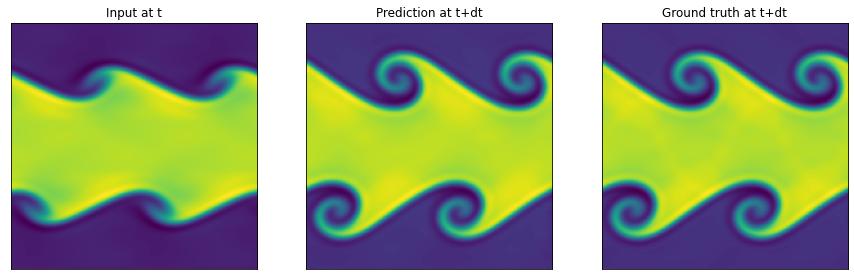

In [51]:
sample = 0
pred =model.predict(xxx[[sample]])
plt.figure(figsize=(15,15))
plt.subplot(1,3,1);plt.imshow(xxx[sample,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Input at t')
plt.subplot(1,3,2);plt.imshow(pred[0,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Prediction at t+dt')
plt.subplot(1,3,3);plt.imshow(yyy[sample,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Ground truth at t+dt')

Text(0.5, 1.0, 'Ground truth at t+dt')

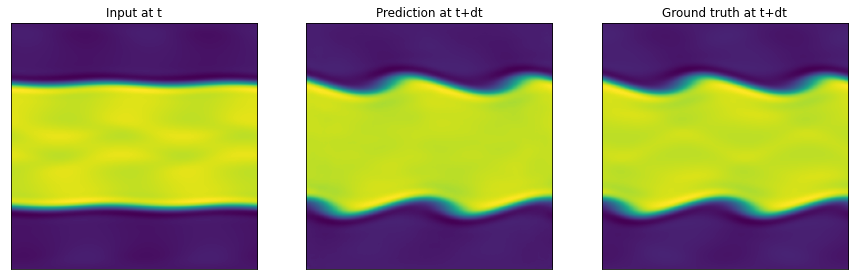

In [50]:
sample = 10
pred =model.predict(xxx[[sample]])
plt.figure(figsize=(15,15))
plt.subplot(1,3,1);plt.imshow(xxx[sample,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Input at t')
plt.subplot(1,3,2);plt.imshow(pred[0,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Prediction at t+dt')
plt.subplot(1,3,3);plt.imshow(yyy[sample,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Ground truth at t+dt')

Text(0.5, 1.0, 'Ground truth at t+dt')

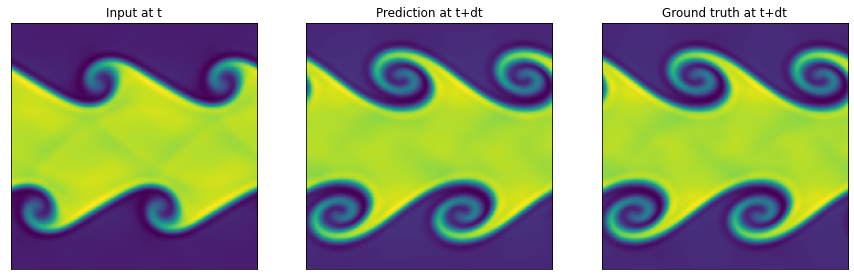

In [49]:
sample = 200
pred =model.predict(xxx[[sample]])
plt.figure(figsize=(15,15))
plt.subplot(1,3,1);plt.imshow(xxx[sample,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Input at t')
plt.subplot(1,3,2);plt.imshow(pred[0,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Prediction at t+dt')
plt.subplot(1,3,3);plt.imshow(yyy[sample,0,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('Ground truth at t+dt')

In [53]:
ls

 IMERG-Monthly-Climatologies-GeoTIFF-Worldfile.zip
 KH_model.h5
 KelvinHelmo.ipynb
 Untitled.ipynb
 coin.3IMERGM_Final_2001-2019_m01.tfw
 coin.3IMERGM_Final_2001-2019_m01.tif
 coin.3IMERGM_Final_2001-2019_m02.tfw
 coin.3IMERGM_Final_2001-2019_m02.tif
 coin.3IMERGM_Final_2001-2019_m03.tfw
 coin.3IMERGM_Final_2001-2019_m03.tif
 coin.3IMERGM_Final_2001-2019_m04.tfw
 coin.3IMERGM_Final_2001-2019_m04.tif
 coin.3IMERGM_Final_2001-2019_m05.tfw
 coin.3IMERGM_Final_2001-2019_m05.tif
 coin.3IMERGM_Final_2001-2019_m06.tfw
 coin.3IMERGM_Final_2001-2019_m06.tif
 coin.3IMERGM_Final_2001-2019_m07.tfw
 coin.3IMERGM_Final_2001-2019_m07.tif
 coin.3IMERGM_Final_2001-2019_m08.tfw
 coin.3IMERGM_Final_2001-2019_m08.tif
 coin.3IMERGM_Final_2001-2019_m09.tfw
 coin.3IMERGM_Final_2001-2019_m09.tif
 coin.3IMERGM_Final_2001-2019_m10.tfw
 coin.3IMERGM_Final_2001-2019_m10.tif
 coin.3IMERGM_Final_2001-2019_m11.tfw
 coin.3IMERGM_Final_2001-2019_m11.tif
 coin.3IMERGM_Final_2001-2019_m12.tfw
 coin.3IMERGM_Final_2001-20

In [57]:
f[1].split(',')

['0',
 '0.3756987154483795',
 '1e-04',
 '0.32919907569885254',
 '0.18177343904972076',
 '0.1126541867852211\n']

'0.18177343904972076'

Text(0, 0.5, 'MAE')

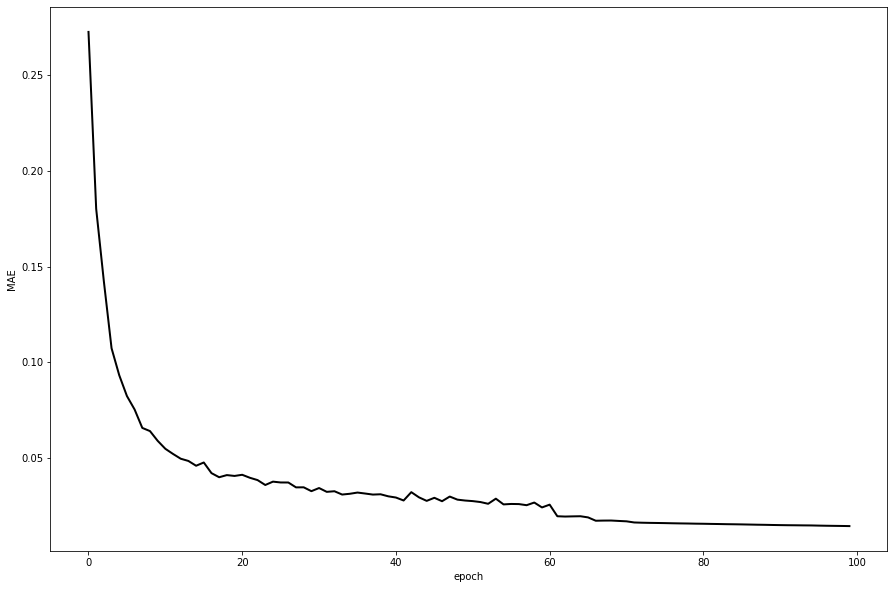

In [67]:
file = 'train step=100 192x192.log'
with open(file) as f:f = f.readlines()
val_loss=[float(i.split(',')[4]) for i in f[1:]]
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(val_loss)),np.array(val_loss)*mean,'-k',linewidth=2)
plt.xlabel('epoch')
plt.ylabel('MAE')